1.Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?  [relevant rubric items: “data exploration”, “outlier investigation”]


The goal of this project is to identify the person of interest, which means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity in Enron scandal. Through machine learning we can find the person of interest based on financial and email data made public as a result of the Enron scandal.
As seen from the pdf of financial data the row ‘TOTAL’ is outlier(plotted salary vs poi and found TOTAL as an outlier). There are many entries in which the payments column is empty and only the stock values are filled, these can also treated as outliers because here our concern is to identify the person of interest. However, if our concern wasn’t person of interest this data can meaningful because these can be fake people added by person of interest intentionally. For this project I will be replacing these NaN values with zero.


In [1]:
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/Users/aishwaryapatil/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
df_enron = pd.DataFrame.from_dict(data_dict, orient='index')
df_enron = df_enron.replace('NaN', np.nan)

# Exploratory Data Analysis of Enron Data

I will be checking for the number of Insiders and Person of interest (POI)

In [3]:
print 'Insiders:', df_enron['poi'].count()
print 'Number of POIs:', df_enron.loc[df_enron.poi == True, 'poi'].count()
print 'Fraction of examples that are POIs:', \
    float(df_enron.loc[df_enron.poi == True, 'poi'].count()) / df_enron['poi'].count()
print 'Number of features:', df_enron.shape[1]

Insiders: 146
Number of POIs: 18
Fraction of examples that are POIs: 0.123287671233
Number of features: 21


As the number of POI's are less , I have used stratified shuffle split which maintains the ratio between POI and non POI while training as well as testing the model.

In [4]:
Features = ['poi', 'email_address', 'salary', 'to_messages', 'deferral_payments', 
                'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 
                'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 
                'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 
                'director_fees', 'deferred_income', 'long_term_incentive', 'from_poi_to_this_person']

FinancialFeatures = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus',
                    'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses',
                    'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 
                    'director_fees']
EmailFeatures = ['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi',
                  'shared_receipt_with_poi']

After seeing the pdf there were a lot of null values in the data. 

In [5]:
print 'Null values in features'
df_enron.isnull().sum()

Null values in features


salary                        51
to_messages                   60
deferral_payments            107
total_payments                21
exercised_stock_options       44
bonus                         64
restricted_stock              36
shared_receipt_with_poi       60
restricted_stock_deferred    128
total_stock_value             20
expenses                      51
loan_advances                142
from_messages                 60
other                         53
from_this_person_to_poi       60
poi                            0
director_fees                129
deferred_income               97
long_term_incentive           80
email_address                 35
from_poi_to_this_person       60
dtype: int64

EmailFeatures have near about same number 60 , the poi must have deleted these or created them purposely.
Loan advances have maximum number of null values.


In [6]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

df_enron = pd.DataFrame.from_dict(data_dict, orient='index')
df_enron = df_enron.replace('NaN', np.nan)

As our purpose is to find the person of interest , I thought of filling the null values with zero.
Removing these would not be a good solution because there are a lot of them, this will remove half of our data.

In [7]:
df_enron[FinancialFeatures] = df_enron[FinancialFeatures].fillna(0)

There are many ways to impute the missing values of email features , I decided to go for median.

In [8]:
df_enron[EmailFeatures] = df_enron[EmailFeatures].fillna(df_enron[EmailFeatures].median())

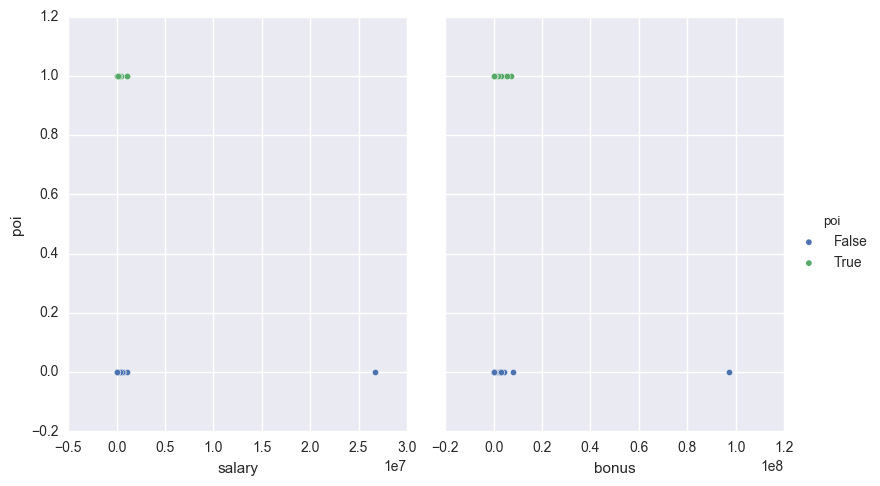

In [18]:
import seaborn as sns
sns.set(color_codes=True)
sns.pairplot(df_enron, x_vars=['salary', 'bonus'], y_vars=['poi'],
             hue='poi', size=5, aspect=.8);

As one can see there is a outlier to the extreme right which is TOTAL

In [11]:
df_enron = df_enron.drop('TOTAL')

2.What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importance of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “properly scale features”, “intelligently select feature”]


Took all of the financial features . 

For email features I engineered two new fetaures fraction_of_messages_to_poi,
fraction_of_messages_from_poi , just using from_message and to_message didn’t make sense because my goal is to identify the person of interest , if  the fraction  number of messages from poi to a particular person(vice versa) is high then the chances are more, that the other person is person of interest.

Scaled the features because some features have relatively high magnitude that others such salary using MinMax scaler. For feature selection step I used Select K Best algorithm.

Performed GridSearch CV and noted the value of best parameters. The best value was for k = 10.

Also applied Principal Component Analysis ,as there might be some features which were related , in order to not miss out on collinearity , I used PCA . 

GridSearchCV gave the best parameters for PCA.


Adding new feature 

In [12]:
df_enron['fraction_of_messages_to_poi'] = df_enron.from_this_person_to_poi / df_enron.from_messages
df_enron['fraction_of_messages_from_poi'] = df_enron.from_poi_to_this_person / df_enron.to_messages

In [20]:
my_dataset = df_enron.to_dict('index')

features_list = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments',
       'exercised_stock_options', 'bonus', 'restricted_stock',
       'shared_receipt_with_poi', 'expenses', 'from_messages', 'other',
       'long_term_incentive', 'fraction_of_messages_to_poi',
       'fraction_of_messages_from_poi']
       

In [21]:
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [22]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from time import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, make_scorer
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [23]:
from tester import test_classifier

3) What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?


Tried using KNearestNeighbor first , which gave  precision of  0.27766 and recall of 0.26774.

Then, performed Logistic Regression which gave a high  precision 0.42534   and recall of  0.27021.

Decision Tree Classifier gave better result with precision of 0.30472 and recall of 0.30350.

(Tried other classifiers also but they were taking too much time to run)



Trying with KNearestNeighbor

In [24]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('Selection',SelectKBest(k=10)),
    ('Pca', PCA()),
    ('clas', KNeighborsClassifier()),
])

In [25]:
parameters = {
    #'scaler__with_centering': (True,False),
    #'vect__max_features': (None, 5000, 10000, 50000),
    #'scaler__with_scaling': (True,False),  # unigrams or bigrams
    'Pca__n_components': ([1,9]),
    'Pca__whiten': (True, False),
    #'Pca__random_state': ([1,100]),
    'Pca__svd_solver':('auto', 'full', 'arpack', 'randomized'),
    'clas__n_neighbors':([1,5])
    #'clas__kernel':('rbf','poly','sigmoid','linear'),
    #'clas__C':([1,100]),
    #'clas__gamma':([0,1])
    #'clas__splitter':('best','random'),
    #'clas__max_features':('log2','sqrt')
}

In [26]:
gs = GridSearchCV(pipeline, parameters,scoring='f1',cv=StratifiedShuffleSplit(labels,1000,random_state = 42))
t0 = time()


In [27]:
gs.fit(features, labels)
print("done in %0.3fs" % (time() - t0))
print gs.best_params_
print gs.best_score_
clf= gs.best_estimator_
dump_classifier_and_data(clf, my_dataset, features_list)

done in 299.495s
{'Pca__n_components': 1, 'Pca__svd_solver': 'auto', 'clas__n_neighbors': 1, 'Pca__whiten': True}
0.239637301587


In [28]:
test_classifier(clf,my_dataset, features_list)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('Selection', SelectKBest(k=10, score_func=<function f_classif at 0x116db39b0>)), ('Pca', PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('clas', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])
	Accuracy: 0.81147	Precision: 0.27766	Recall: 0.25850	F1: 0.26774	F2: 0.26212
	Total predictions: 15000	True positives:  517	False positives: 1345	False negatives: 1483	True negatives: 11655



Got precision and recall less than 0.3  with KNearestNeighbor

Tried Support Vector Machine but it was taking a lot of time to run.

Logistic Regression :

In [29]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('Selection',SelectKBest(k=10)),
    ('Pca', PCA()),
    ('clas', LogisticRegression()),
])

In [30]:
parameters = {
    #'scaler__with_centering': (True,False),
    #'vect__max_features': (None, 5000, 10000, 50000),
    #'scaler__with_scaling': (True,False),  # unigrams or bigrams
    'Pca__n_components': ([1,9]),
    'Pca__whiten': (True, False),
    #'Pca__random_state': ([1,100]),
    'Pca__svd_solver':('auto', 'full', 'arpack', 'randomized'),
    'clas__penalty' :('l1','l2')
    #'clas__n_neighbors':([1,5])
    #'clas__kernel':('rbf','poly','sigmoid','linear'),
    #'clas__C':([1,100]),
    #'clas__gamma':([0,1])
    #'clas__splitter':('best','random'),
    #'clas__max_features':('log2','sqrt')
}

In [31]:
gs = GridSearchCV(pipeline, parameters,scoring='f1',cv=StratifiedShuffleSplit(labels,1000,random_state = 42))
t0 = time()


In [32]:
gs.fit(features, labels)
print("done in %0.3fs" % (time() - t0))
print gs.best_params_
print gs.best_score_
clf= gs.best_estimator_
dump_classifier_and_data(clf, my_dataset, features_list)

done in 286.374s
{'Pca__n_components': 9, 'clas__penalty': 'l2', 'Pca__svd_solver': 'auto', 'Pca__whiten': True}
0.225719047619


In [33]:
test_classifier(clf,my_dataset, features_list)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('Selection', SelectKBest(k=10, score_func=<function f_classif at 0x116db39b0>)), ('Pca', PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)), ('clas', LogisticRegressio...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
	Accuracy: 0.85740	Precision: 0.42535	Recall: 0.19800	F1: 0.27021	F2: 0.22170
	Total predictions: 15000	True positives:  396	False positives:  535	False negatives: 1604	True negatives: 12465



Precision looks good but recall is below 0.3

Decision Tree Classifier

Code in poi_id.py file

4.What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).  [relevant rubric item: “tune the algorithm”]



Classifiers have parameters which affect the performance of the model. 

To tune parameters means to adjust the parameters of the classifier in order to give the best performance.

The parameters involved with my final classifier ,that is Decision Tree classifier , were splitter and random state.

Used GridSearchCV in order to find the best parameters. 


5.What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?  [relevant rubric item: “validation strategy”]


After training the model with a dataset , it is important to test the model with a different dataset , this is known as validation .

Classic mistake one can make is using the training data for testing the model , it is important to either spilt the data into different parts one for training and one for testing , or use a different dataset for both the task. 

Used StratifiedShuffleSplit for splitting my data with 1000 iterations .


6.Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. [relevant rubric item: “usage of evaluation metrics”]


Evaluation metrics I are precision and recall . With Decision Tree Classifier I got a precision of 0.30472 and recall of 0.30350
